In [36]:
# ======================
# 0. LIBRARIES
# ======================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import datetime

In [18]:
# Step 1: Generate Synthetic Sample Data (Mock sales_data.csv)
def generate_sample_data():
    np.random.seed(42)
    dates = pd.date_range(start='2019-01-01', periods=60, freq='ME')
    sales = 20000 + np.arange(60) * 500 + np.sin(np.arange(60) / 12 * 2 * np.pi) * 10000 + np.random.normal(0, 2000, 60)
    promotions = np.random.choice([0, 1], size=60, p=[0.7, 0.3])
    seasons = ['Winter', 'Spring', 'Summer', 'Fall'] * 15
    economic_index = 1.0 + np.random.normal(0, 0.1, 60)
    
    df = pd.DataFrame({
        'Date': dates,
        'Sales': sales.astype(int),
        'Promotions': promotions,
        'Season': seasons[:60],  # Trim to 60
        'Economic_Index': economic_index
    })
    df.to_csv('sales_data.csv', index=False)
    return df

df = generate_sample_data()
print("Sample Data Head:\n", df.head())

Sample Data Head:
         Date  Sales  Promotions  Season  Economic_Index
0 2019-01-31  20993           0  Winter        0.808123
1 2019-02-28  25223           0  Spring        0.997349
2 2019-03-31  30955           0  Summer        1.006023
3 2019-04-30  34546           0    Fall        1.246324
4 2019-05-31  30191           1  Winter        0.980764


In [19]:
# Step 2: Data Preprocessing
# Convert Date to datetime and set index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Encode categorical 'Season'
le = LabelEncoder()
df['Season'] = le.fit_transform(df['Season'])


In [20]:
df.head()

,Sales,Promotions,Season,Economic_Index
Date,,,,
2019-01-31,20993,0,3,0.808123
2019-02-28,25223,0,1,0.997349
2019-03-31,30955,0,2,1.006023
2019-04-30,34546,0,0,1.246324
2019-05-31,30191,1,3,0.980764


In [21]:
# Create features: Month, Year for time trends
df['Month'] = df.index.month
df['Year'] = df.index.year

# Features and target
X = df[['Promotions', 'Season', 'Economic_Index', 'Month', 'Year']]
y = df['Sales']

In [26]:
df.sort_index()
df.tail()

,Sales,Promotions,Season,Economic_Index,Month,Year
Date,,,,,,
2023-08-31,44362,1,0,1.041278,8,2023
2023-09-30,37661,0,3,1.082206,9,2023
2023-10-31,37881,1,1,1.189679,10,2023
2023-11-30,41002,1,2,0.975461,11,2023
2023-12-31,46451,0,0,0.924626,12,2023


In [23]:
df['Year'].value_counts()

Year
2019    12
2020    12
2021    12
2022    12
2023    12
Name: count, dtype: int64

In [41]:
# Split train/test to predict 2023
X_train = df[df['Year'] < 2023]
X_test = df[df['Year'] >= 2023]

y_train = df[df['Year'] < 2023]
y_test = df[df['Year'] >= 2023]


X_train = X_train[['Promotions', 'Season', 'Economic_Index', 'Month', 'Year']]
X_test = X_test[['Promotions', 'Season', 'Economic_Index', 'Month', 'Year']]

y_train = y_train['Sales']
y_test = y_test['Sales']


In [42]:
# Step 3: Train Random Forest Model
model_RF = RandomForestRegressor(n_estimators=100, random_state=42)
model_RF.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [43]:
# Step 3: Train GMB
model_GB = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_GB.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [70]:
# Step 4: Evaluate on Test Set
y_pred_RF = model_RF.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_RF)
print(f'Test MAE: {mae:.2f} units')

y_pred_GB = model_GB.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_GB)
print(f'Test MAE: {mae:.2f} units')

Test MAE: 8200.21 units
Test MAE: 7095.82 units


In [51]:
# Step 5: Forecast Next 12 Months
future_dates = pd.date_range(start=df.index[-1] + pd.offsets.MonthBegin(1), periods=12, freq='ME')
Season = [month%12 // 3  for month in range(0, 12)]
Season

[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]

In [84]:
dates_f = pd.date_range(start='2024-01-01', periods=12, freq='ME')
dates_f

DatetimeIndex(['2024-01-31', '2024-02-29', '2024-03-31', '2024-04-30',
               '2024-05-31', '2024-06-30', '2024-07-31', '2024-08-31',
               '2024-09-30', '2024-10-31', '2024-11-30', '2024-12-31'],
              dtype='datetime64[ns]', freq='ME')

In [73]:
future_df = pd.DataFrame({
    'Promotions': [0] * 12,  # Assume no promotions
    'Season': Season,  # Map month to season
    'Economic_Index': [df['Economic_Index'].mean()] * 12,  # Average economic index
    'Month': future_dates.month,
    'Year': future_dates.year
})
forecasts_GB = model_GB.predict(future_df)
forecasts_RF = model_RF.predict(future_df)
forecasts_GB

array([40665.40513693, 42425.04010431, 45158.0709268 , 47205.42317888,
       47731.48892342, 44786.79053607, 41488.65762717, 33358.96419687,
       30339.80129921, 29459.71804606, 30466.15229355, 35307.04021143])

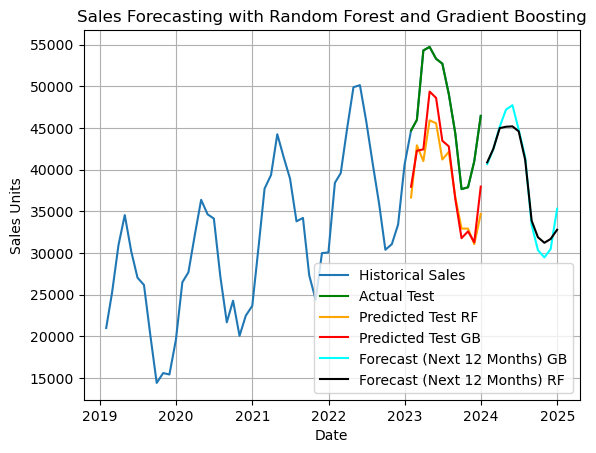

In [83]:
# Step 6: Visualize and Save Plot
plt.figure()
plt.plot(df.index, df['Sales'], label='Historical Sales')
plt.plot(X_test.index, y_test, label='Actual Test', color='green')
plt.plot(X_test.index, y_pred_RF, label='Predicted Test RF', color='orange')
plt.plot(X_test.index, y_pred_GB, label='Predicted Test GB', color='red')
plt.plot(future_dates, forecasts_GB, label='Forecast (Next 12 Months) GB', color='Cyan')
plt.plot(future_dates, forecasts_RF, label='Forecast (Next 12 Months) RF', color='Black')

plt.title('Sales Forecasting with Random Forest and Gradient Boosting')
plt.xlabel('Date')
plt.ylabel('Sales Units')
plt.legend()
plt.grid(True)
plt.savefig('simple_sales_forecast_plot.png') 

plt.show()

In [85]:
# Step 7: Output Forecast Table
forecast_table = pd.DataFrame({'Date': future_dates, 'Forecasted Sales': forecasts_GB.astype(int)})
print("Forecasts for Next 12 Months:\n", forecast_table)

Forecasts for Next 12 Months:
          Date  Forecasted Sales
0  2024-01-31             40665
1  2024-02-29             42425
2  2024-03-31             45158
3  2024-04-30             47205
4  2024-05-31             47731
5  2024-06-30             44786
6  2024-07-31             41488
7  2024-08-31             33358
8  2024-09-30             30339
9  2024-10-31             29459
10 2024-11-30             30466
11 2024-12-31             35307
